<h1>Preprocessing Script</h1>

<h3> Task 1: Convert the random sized images into standard size</h3>


Import these modules for the preprocessing of the data

In [1]:
import PIL 
from PIL import Image
from __future__ import print_function
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import csv


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# The following function converts all the images to 100 x 100 sized images
def convert_to_100x100(path, ori_path):
    # counters for processed files
    count = 0 
    faulty_files = 0
    
    # check if the directory already exists 
    if(not os.path.exists(path)):
        os.mkdir(path)
        images = sorted(os.listdir(ori_path))
        for image in images:
            image_file_path = ori_path + image

            try:
                img = Image.open(image_file_path) # throws IOError    
                img = img.resize((100, 100), PIL.Image.ANTIALIAS)
                img.save(path + "/" + image)

            except IOError: # if IOError is thrown, then the image is faulty
                print("image %s is faulty" %(image_file_path))
                faulty_files += 1 
                continue


            if(count % 100 == 0):
                print("Working on %dth image" %(count))

            count += 1

    else:
        print("path %s already exists" %(path))
    
    # print the statistical output of the process
    print("Total Files normalized: %d\nFaulty Files: %d\n" %(count, faulty_files))

In [6]:
'''Set the constant paths here'''
root = "../Data"
path = "../Data/Resized_final_data"
ori_path = "../Data/train_4/"
csv_path = "../Data/train_info.csv"

In [4]:
# preprocess Preliminary data
convert_to_100x100(path, ori_path)

path ../Data/Resized_final_data already exists
Total Files normalized: 0
Faulty Files: 0



<h3>Task 2: Load the labels for all the required images</h3>

In [7]:
'''Set a few constants for the further script'''

image_size = 100  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_depth = 3 # coloured images in RGB format 

In [8]:
def load_data(folder, min_num_images):
    """Load the data from the provided folder"""
    # get all the images from the folder
    image_files = os.listdir(folder)

    # create n dimensional arrays for the images and their numbers
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, image_depth),
                         dtype=np.float32)
    image_numbers = np.ndarray(shape=(len(image_files)), dtype=np.int64)
    
    print("Loading Images from %s" %folder) # feedback message
  
    num_images = 0 # counter for number of images
    
    for image in image_files: # enter the main loop
        image_file = os.path.join(folder, image) # path of file 
        try:
            # normalize the image pixel values around its mean
            image_data = (ndimage.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            
            if image_data.shape != (image_size, image_size, image_depth):#removing grayscale images
                print('Unexpected image shape: %s of image %s\nIts ok, skipping it' % 
                                (str(image_data.shape), image_file))
                continue
            
            dataset[num_images, :, :, :] = image_data
            image_numbers[num_images] = int(image.split(".")[0])
            num_images = num_images + 1
        except IOError as e:
              print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :, :] # exclude the place holder for the faulty images
    image_numbers = image_numbers[0: num_images]
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset, image_numbers

In [10]:
# load the Resized images
try:
    train_dataset, train_names = load_data(path, 20000)
    
except Exception as e:
    print('Error occured: ', e)
    

Loading Images from ../Data/Resized_final_data
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/4056.jpg
Its ok, skipping it
Unexpected image shape: (100, 100, 4) of image ../Data/Resized_final_data/22580.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/72131.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/40619.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/76403.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/74665.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/43755.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/47723.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of image ../Data/Resized_final_data/46892.jpg
Its ok, skipping it
Unexpected image shape: (100, 100) of imag

In [11]:
train_dataset.shape, train_names.shape

((25384, 100, 100, 3), (25384,))

In [12]:
train_names[:10]

array([72224, 70722, 70230, 49411, 23946, 48081, 23524, 71471, 28925, 43874])

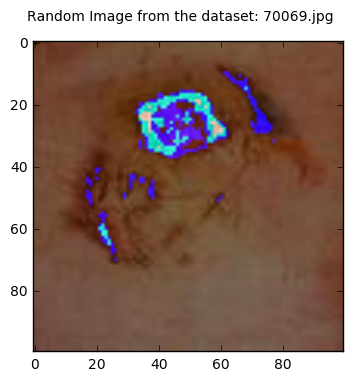

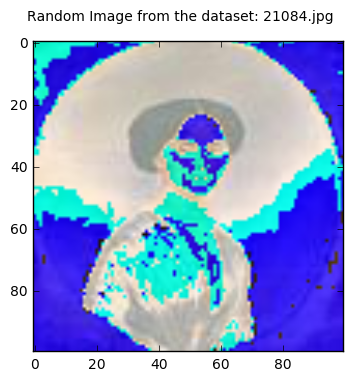

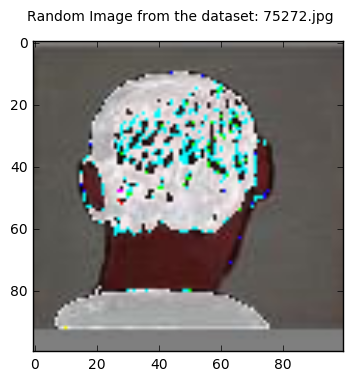

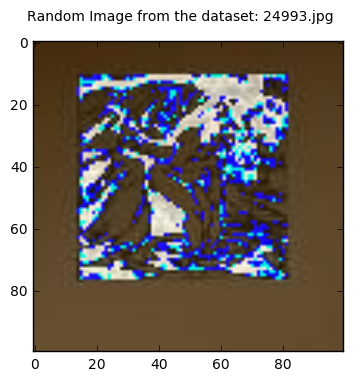

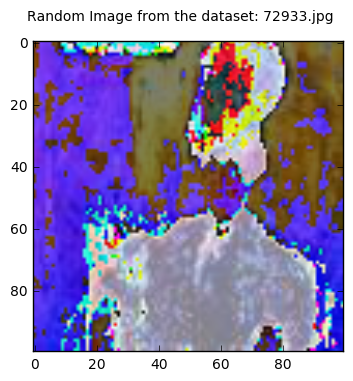

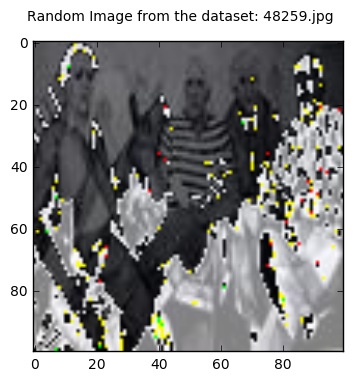

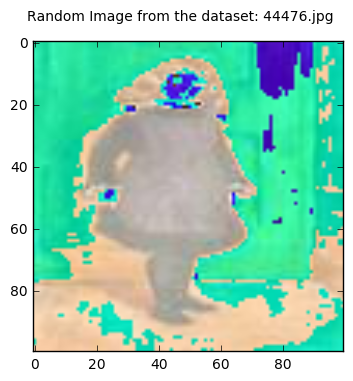

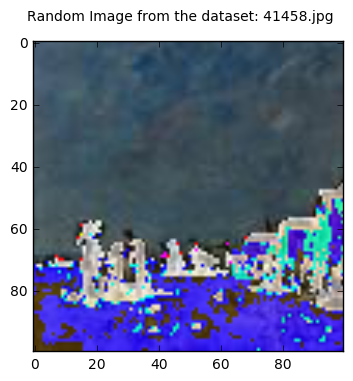

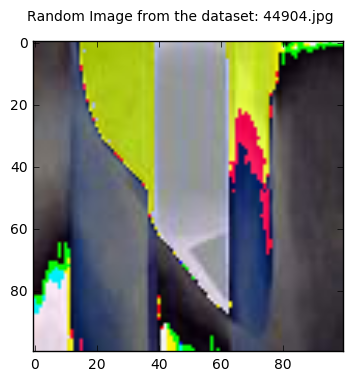

In [13]:
for i in range(1, 10):
    random_index = np.random.randint(train_dataset.shape[0])
    plt.figure().suptitle("Random Image from the dataset: %d.jpg" %(train_names[random_index]))
    plt.imshow(train_dataset[random_index])


In [14]:
def load_csv(path):
    train_labels = []
    with open(path, 'rb') as csvfile:
        num_labels = 0
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in spamreader:
            train_labels.append([row[0].split(".")[0], row[4]])
            num_labels += 1
    train_labels = train_labels[1:]
    return train_labels

In [16]:
data_labels = load_csv(csv_path)
print(len(data_labels))
data_labels[:20]

79433


[['102257', 'abstract'],
 ['75232', 'abstract'],
 ['29855', 'mythological painting'],
 ['62252', 'abstract'],
 ['63861', 'abstract'],
 ['53180', 'bird-and-flower painting'],
 ['70944', 'landscape'],
 ['59792', 'religious painting'],
 ['48138', 'landscape'],
 ['99442', 'marina'],
 ['23508', 'bird-and-flower painting'],
 ['82352', 'religious painting'],
 ['27254', 'bird-and-flower painting'],
 ['47145', 'bird-and-flower painting'],
 ['59145', 'abstract'],
 ['16876', 'religious painting'],
 ['28908', 'genre painting'],
 ['48177', 'still life'],
 ['7486', 'religious painting'],
 ['35766', 'religious painting']]

In [17]:
print(train_dataset.shape)
print(train_names.shape)
len(data_labels)

(25384, 100, 100, 3)
(25384,)


79433

In [18]:
def load_Labels(train_names, train_labels): # return the labels for the examples
    count = 0;
    labels = []
    for count in range(train_names.shape[0]):
        for label in train_labels:
            if(label[0] == str(train_names[count])):
                labels.append(label[1])
                break
        
        count += 1
        
        if(count % 500 == 0):
            print("Working on Image no. %d" %count)
        
    return labels
    

## The following step requires some time. So, please wait

In [19]:
# filter the labels only that are required
train_labels = load_Labels(train_names, data_labels)
len(train_labels)

Working on Image no. 500
Working on Image no. 1000
Working on Image no. 1500
Working on Image no. 2000
Working on Image no. 2500
Working on Image no. 3000
Working on Image no. 3500
Working on Image no. 4000
Working on Image no. 4500
Working on Image no. 5000
Working on Image no. 5500
Working on Image no. 6000
Working on Image no. 6500
Working on Image no. 7000
Working on Image no. 7500
Working on Image no. 8000
Working on Image no. 8500
Working on Image no. 9000
Working on Image no. 9500
Working on Image no. 10000
Working on Image no. 10500
Working on Image no. 11000
Working on Image no. 11500
Working on Image no. 12000
Working on Image no. 12500
Working on Image no. 13000
Working on Image no. 13500
Working on Image no. 14000
Working on Image no. 14500
Working on Image no. 15000
Working on Image no. 15500
Working on Image no. 16000
Working on Image no. 16500
Working on Image no. 17000
Working on Image no. 17500
Working on Image no. 18000
Working on Image no. 18500
Working on Image no. 

25384

In [21]:
# check if the lables have been properly generated
(train_names[:20], train_labels[:20])

(array([72224, 70722, 70230, 49411, 23946, 48081, 23524, 71471, 28925,
        43874, 47155, 70451, 48076,  4524, 23600, 44185, 75007, 72556,
        24958,  7646]),
 ['landscape',
  'genre painting',
  'abstract',
  'portrait',
  'portrait',
  'allegorical painting',
  'portrait',
  'landscape',
  'landscape',
  'genre painting',
  'still life',
  'portrait',
  'mythological painting',
  'religious painting',
  'sketch and study',
  'marina',
  'cityscape',
  'illustration',
  'still life',
  'abstract'])

In [22]:
# filter the images that do not have a label
def filter_Non_Labelled(data, labels):
    index = 0
    while index < len(labels):
        if(labels[index] == ""):
            print("deleting %d th image" %index)
            data = np.delete(data, index, axis=0)
            labels.pop(index)
        
        else:
            index += 1
        
    return (data, labels)

In [23]:
train_dataset, train_labels = filter_Non_Labelled(train_dataset, train_labels)
(train_dataset.shape, len(train_labels))

deleting 31 th image
deleting 226 th image
deleting 369 th image
deleting 473 th image
deleting 474 th image
deleting 840 th image
deleting 887 th image
deleting 977 th image
deleting 1125 th image
deleting 1125 th image
deleting 1497 th image
deleting 1522 th image
deleting 1536 th image
deleting 1592 th image
deleting 1610 th image
deleting 1623 th image
deleting 1646 th image
deleting 1784 th image
deleting 1986 th image
deleting 2086 th image
deleting 2126 th image
deleting 2169 th image
deleting 2208 th image
deleting 2400 th image
deleting 2541 th image
deleting 2548 th image
deleting 2570 th image
deleting 2777 th image
deleting 2778 th image
deleting 2842 th image
deleting 2898 th image
deleting 2900 th image
deleting 2908 th image
deleting 2908 th image
deleting 3254 th image
deleting 3575 th image
deleting 3644 th image
deleting 3738 th image
deleting 3742 th image
deleting 3777 th image
deleting 3838 th image
deleting 4114 th image
deleting 4349 th image
deleting 4365 th ima

((25109, 100, 100, 3), 25109)

In [24]:
# create a dictionary of mappings of labels to names
unique = sorted(list(set(train_labels)))
num_labels = len(unique)
label_mappings = {v: k for k, v in dict(enumerate(unique)).iteritems()}
label_mappings

{'abstract': 0,
 'advertisement': 1,
 'allegorical painting': 2,
 'animal painting': 3,
 'battle painting': 4,
 'bijinga': 5,
 'bird-and-flower painting': 6,
 'calligraphy': 7,
 'capriccio': 8,
 'caricature': 9,
 'cityscape': 10,
 'cloudscape': 11,
 'design': 12,
 'figurative': 13,
 'flower painting': 14,
 'genre painting': 15,
 'history painting': 16,
 'illustration': 17,
 'interior': 18,
 'landscape': 19,
 'literary painting': 20,
 'marina': 21,
 'miniature': 22,
 'mythological painting': 23,
 'nude painting (nu)': 24,
 'panorama': 25,
 'pastorale': 26,
 'portrait': 27,
 'poster': 28,
 'quadratura': 29,
 'religious painting': 30,
 'self-portrait': 31,
 'shan shui': 32,
 'sketch and study': 33,
 'still life': 34,
 'symbolic painting': 35,
 'tessellation': 36,
 'vanitas': 37,
 'veduta': 38,
 'wildlife painting': 39,
 'yakusha-e': 40}

In [25]:
# function to hot encode the labels
def hot_encode(labels):
    encoded_labels = [[0 for i in range(0, len(label_mappings))] for j in range(0, len(train_labels))]
    for i in range(0, len(labels)):
        encoded_labels[i][label_mappings[labels[i]]] = 1
    return np.array(encoded_labels, dtype=np.float32)

In [26]:
encoded_train_labels = hot_encode(train_labels[:]) # pass by value

# check for the shapes of the input data:
(encoded_train_labels.shape, encoded_train_labels[0])

((25109, 41),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.], dtype=float32))

In [29]:
''' For pickling the data acquired till now '''

# data dictionary


training_percentage = 70
cross_validation_percentage = 10
# remaining = test data

train_partition = (len(train_dataset) * training_percentage) / 100
cv_partition = (len(train_dataset) * (training_percentage + cross_validation_percentage)) / 100

data_dict = {
    "train_data" : train_dataset[: train_partition],
    "train_labels" : encoded_train_labels[: train_partition],
    "cv_data" : train_dataset[train_partition: cv_partition],
    "cv_labels" : encoded_train_labels[train_partition: cv_partition],
    "test_data" : train_dataset[cv_partition : ],
    "test_labels" : encoded_train_labels[cv_partition : ],
    
    "label_mapping" : label_mappings
}

if(not os.path.isfile(os.path.join(root, "Data_final.pickle"))):
    with open(os.path.join(root, "Data_final.pickle"), "wb") as pickle_file:
        pickle.dump(data_dict, pickle_file, pickle.HIGHEST_PROTOCOL)
        print("Pickling complete")
        
else:
    print("data is already pickled")

Pickling complete


## Finally, check if the data is properly pickled

In [31]:
with open(os.path.join(root, "Data_final.pickle"), "rb") as pickle_file:
    my_dict = pickle.load(pickle_file)
    
len(my_dict)

7